In [1]:
import os

import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

import math

crs_32188 = {'init' :'epsg:32188'}
crs_4326 = {'init': 'epsg:4326'}

## Load sidewalk polygons
Sidewalks data, [Trottoir et îlot (Base de données des actifs de voirie)](http://donnees.ville.montreal.qc.ca/dataset/voirie-trottoir-ilot), is retreived from the Montreal Open Data web portal. It is a list of polygons representing parts of the sidewalks. 

In [2]:
df = gpd.read_file('../data/VOI_TROTTOIR_S_T12.shp')
df.crs = crs_32188
print(df.shape[0],'sidewalks polygons')

85247 sidewalks polygons


## Estimate width
Montreal's sidewalks are modeled differently from Toronto's and NYC's sidewalks. Each polygon is at most covering one street section's side. It is even common to have 2 polygons covering one street section's side. Therefore we saw an opportunity to simplify the approach to estimate the width. 

A simple approximation is to suppose that each polygon is a rectangle. Then using the polygon length $l$, perimeter $p$ and area $a$, it is possible to compute the width $w$ from these equations:
* $lw = a$
* $2l + 2w = p$

Which leads to:

$$2w^2-pw+2a=0$$

and then:
$$w_{1,2} = \frac{p\pm \sqrt{p^2-16a}}{4}$$

We use the *minus* side of the equation.

In [3]:
df['area']=df['geometry'].area
df['perimeter']=df['geometry'].length

In [4]:

def extract_minus(row):
    try:
        return row.perimeter/4-math.sqrt(row.perimeter*row.perimeter-16*row.area)/4
    except:
        return None

In [5]:
df['width'] = df.apply(lambda x: extract_minus(x), axis=1)

## Save sidewalks with width
Convert data to EPSG 4326 and and save it in json format for mapping.

In [6]:
df = df.to_crs(crs_4326)
df.crs

{'init': 'epsg:4326'}

In [7]:
df.CATEGORIET.unique()

array(['Trottoir', 'Bordure', 'Bordure - autoroute',
       'Trottoir - autoroute'], dtype=object)

We keep only sidewalks and infrastructures for pedestrians 

In [8]:
df = df[(df.CATEGORIET=='Trottoir') & (df.UTILISATIO=='Piéton')]

In [9]:
with open('../sidewalkwidths_mtl.json', 'w') as f:
    f.write(df.to_json())

## Summary Statistics
This section takes the geojson includng sidewalk widths and produces some summary statistics. It also includes the ability to produces these statistics based on geographic boundaries, such as City Council Districts.

In [9]:
df.width.describe()

count    63110.000000
mean         2.025922
std          0.988439
min          0.147342
25%          1.495127
50%          1.593333
75%          2.103746
max         14.900572
Name: width, dtype: float64

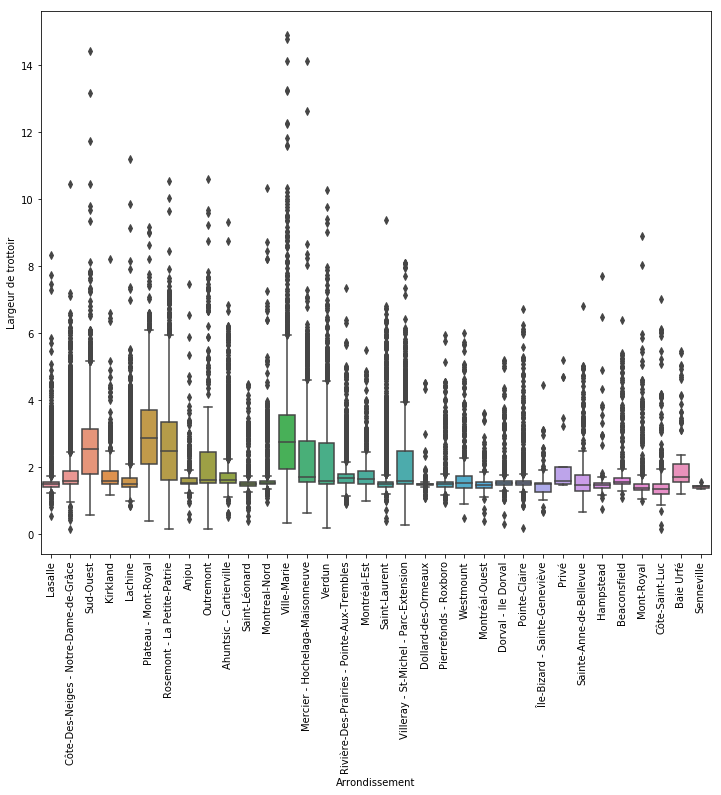

In [10]:
plt.figure(figsize=(12,10))
plt.xticks(rotation=90)
sns.boxplot(x="Arrondissement", 
            y="Largeur de trottoir", 
            data=df.rename(columns={'PROPRIETAI':'Arrondissement','width':'Largeur de trottoir'} ));